# Эксперименты с моделью


1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Загрузка данных, выделение числовых и категориальных признаков, удаление пустых признаков

In [4]:
train = pd.read_csv('orange_small_churn_train_data.csv', index_col = 0)
num = np.array(train.columns[:190])
cat = np.array(train.columns[190:230])
num_cols = np.array(num[np.array(pd.notnull(train[num]).any())])
cat_cols = np.array(cat[np.array(pd.notnull(train[cat]).any())])

Оставим категориальные признаки с менее чем 100 значениями, чтобы разреженная матрица не получилась слишком огромной

In [5]:
cats = []
for i in cat_cols:
    if len(train[i].unique()) <= 100:
        cats.append(i)
cats = np.array(cats)

In [10]:
# У последнего объекта пропущено значение целевого признака
train_num = train[num_cols][:-1]
train_cat = train[cats][:-1]
y_train = train['labels'][:-1]

In [28]:
y_train.value_counts()

-1.0    16921
 1.0     1377
Name: labels, dtype: int64

Заполнение пропущенных значений

In [12]:
train_num = train_num.fillna(0)
train_cat = train_cat.fillna('NaN')

Кодирование категориальных данных с помощью DictVectorizer

In [13]:
from sklearn.feature_extraction import DictVectorizer
d = DictVectorizer(sparse = False)
train_cat = pd.DataFrame(d.fit_transform(train_cat.T.to_dict().values()))

In [14]:
X_train = pd.concat([train_num, train_cat], axis = 1)

Разбиение обучающей выборки на 3 фолда

In [15]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 3)

Построим кривые обучения модели градиентного бустинга

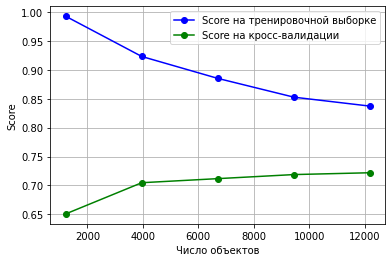

In [23]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import learning_curve
from sklearn.ensemble import GradientBoostingClassifier
train_sizes_abs, train_scores, test_scores = learning_curve(
    GradientBoostingClassifier(), X_train, y_train, 
               cv = skf, scoring = 'roc_auc', n_jobs = -1)
train_scores_mean = np.mean(train_scores, axis = 1)
test_scores_mean = np.mean(test_scores, axis = 1)
plt.figure()
plt.xlabel('Число объектов')
plt.ylabel('Score')
plt.grid()
plt.plot(train_sizes_abs, train_scores_mean, 'o-', color = 'b', label = 'Score на тренировочной выборке')
plt.plot(train_sizes_abs, test_scores_mean, 'o-', color = 'g', label = 'Score на кросс-валидации')
plt.legend()
plt.show()

С увеличением числа объектов тренировочной выборки увеличивается качество на кросс-валидации - необходимо использовать всю выборку.

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

Оценим качество модели без весов:

In [24]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(GradientBoostingClassifier(), X_train, 
                y_train, scoring = 'roc_auc', cv = skf, n_jobs = -1)
print('Среднее качество без весов =', scores.mean())

Среднее качество без весов = 0.7195810759015654


Варианты весов: 1:5, 1:8, 1:10

In [27]:
sample_weight1 = np.array([1 if x == -1 else 5 for x in y_train])
sample_weight2 = np.array([1 if x == -1 else 8 for x in y_train])
sample_weight3 = np.array([1 if x == -1 else 10 for x in y_train])
for sample_weight in sample_weight1, sample_weight2, sample_weight3:
    scores = cross_val_score(GradientBoostingClassifier(), X_train, y_train, 
            scoring = 'roc_auc', cv = skf, fit_params = {'sample_weight': sample_weight}, n_jobs = -1)
    print('Среднее качество =', scores.mean())

Среднее качество = 0.7232713061383661
Среднее качество = 0.7238218726807273
Среднее качество = 0.7215414566506416


Лучшее качество показали веса **1:8**

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [34]:
for size in [8000, 10000, 12000]:
    ind = y_train[y_train == -1].sample(size).index
    scores = cross_val_score(GradientBoostingClassifier(), X_train.drop(ind), y_train.drop(ind),
                             scoring = 'roc_auc', cv = skf, n_jobs = -1)
    print(f'Отношение классов = {(16921 - size)/ 1377}:1, среднее качество = {scores.mean()}')

Отношение классов = 6.478576615831518:1, среднее качество = 0.7215702268975649
Отношение классов = 5.026143790849673:1, среднее качество = 0.7230493282576882
Отношение классов = 3.5737109658678285:1, среднее качество = 0.7140469735332268


Лучшее качество достигнуто при удалении 10000 объектов класса '-1' 

3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

При заполнении пропущенных числовых значений нулями среднее качество равно 0.7195810759015654.  
Заполним пропущенные числовые значения средними по столбцам.

In [36]:
train_num = train[num_cols][:-1].fillna(train[num_cols].mean())
X_train_means = pd.concat([train_num, train_cat], axis = 1)
scores = cross_val_score(GradientBoostingClassifier(), X_train_means,
                         y_train, scoring = 'roc_auc', cv = skf, n_jobs = -1)
print ('Качество при заполнение средними =', scores.mean())

Качество при заполнение средними = 0.72778986693576


Теперь заполним числовые значения медианами по столбцам

In [37]:
train_num = train[num_cols][:-1].fillna(train[num_cols].median())
X_train_medians = pd.concat([train_num, train_cat], axis = 1)
scores = cross_val_score(GradientBoostingClassifier(), X_train_medians,
                         y_train, scoring = 'roc_auc', cv = skf, n_jobs = -1)
print ('Качество при заполнение медианами =', scores.mean())

Качество при заполнение медианами = 0.722524579842247


Заполнение средними даёт лучшее качество. Заменим X_train:

In [38]:
X_train = X_train_means

4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

Кодирование категориальных данных было осуществлено с помощью DictVectorizer (метод One Hot Encoding).  
Теперь используем метод label encoding - кодирование каждой категории уникальным целым числом.

In [39]:
from sklearn.preprocessing import LabelEncoder
l = LabelEncoder()
train_cat = train[cat_cols][:-1]
train_cat = train_cat.fillna('NaN')
# Заполним средними числовые признаки
train_num = train[num_cols][:-1].fillna(train[num_cols].mean())

for i in cat_cols:
    train_cat[i] = l.fit_transform(train_cat[i])
X_train_l = pd.concat([train_num, train_cat], axis = 1)
scores = cross_val_score(GradientBoostingClassifier(), X_train_l,
                y_train, scoring = 'roc_auc', cv = skf, n_jobs = -1)
print('Качество при кодировании методом "label encoding" =', scores.mean())

Качество при кодировании методом "label encoding" = 0.7265973029585487


Используем метод кодирования частотами значений признака в каждом столбце:

In [40]:
train_cat = train[cat_cols][:-1]
train_cat = train_cat.fillna('NaN')
for i in cat_cols:
    freq = train_cat[i].value_counts()
    train_cat[i] = np.array([freq[x] for x in train_cat[i]])
X_train_f = pd.concat([train_num, train_cat], axis = 1)
scores = cross_val_score(GradientBoostingClassifier(), X_train_f,
                y_train, scoring = 'roc_auc', cv = skf, n_jobs = -1)
print('Качество при кодировании частотами =', scores.mean())

Качество при кодировании частотами = 0.7324317649877933


Кодирование категориальных признаков частотами даёт лучшее качество. Заменим X_train:

In [86]:
X_train = X_train_f

5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

Удаление признаков с нулевой дисперсией:

In [42]:
from sklearn.feature_selection import VarianceThreshold
X_train_1 = VarianceThreshold().fit_transform(X_train)

In [43]:
from sklearn.linear_model import Lasso
lasso = Lasso(max_iter = 10000).fit(X_train_1, y_train)
non_zero_w = np.flatnonzero(lasso.coef_)
X_train_l1 = X_train_1.take(non_zero_w, axis = 1)
scores = cross_val_score(GradientBoostingClassifier(), X_train_l1,
                y_train, scoring = 'roc_auc', cv = skf, n_jobs = -1)
print('Качество при использовании l1-регуляризации =', scores.mean())

Качество при использовании l1-регуляризации = 0.6853795803593621


Качество при l1-регуляризации намного ниже. Используем **ANOVA F-value** для отбора лучших признаков: 

In [46]:
from sklearn.feature_selection import SelectKBest
for i in [40, 50, 60, 70, 80, 90, 100]:
    X_f_classif = SelectKBest(k = i).fit_transform(X_train_1, y_train)
    scores = cross_val_score(GradientBoostingClassifier(),
    X_f_classif, y_train, scoring = 'roc_auc', cv = skf, n_jobs = -1)
    print(f'Качество при отборе {i} лучших признаков =', scores.mean())

Качество при отборе 40 лучших признаков = 0.736151744558803
Качество при отборе 50 лучших признаков = 0.7373003853630617
Качество при отборе 60 лучших признаков = 0.7373210106209843
Качество при отборе 70 лучших признаков = 0.7359117821422491
Качество при отборе 80 лучших признаков = 0.7359671208078273
Качество при отборе 90 лучших признаков = 0.7338750444506603
Качество при отборе 100 лучших признаков = 0.7344092784600345


Лучшее качество достигается при отборе от 50 до 70 лучших признаков. Найдём подбором число признаков, для которого качество максимально:

In [48]:
for i in range(50, 70):
    X_f_classif = SelectKBest(k = i).fit_transform(X_train_1, y_train)
    scores = cross_val_score(GradientBoostingClassifier(),
    X_f_classif, y_train, scoring = 'roc_auc', cv = skf, n_jobs = -1)
    print(f'Число признаков: {i}, AUC-ROC =', scores.mean())

Число признаков: 50, AUC-ROC = 0.7376623508171116
Число признаков: 51, AUC-ROC = 0.7374395181677488
Число признаков: 52, AUC-ROC = 0.7384928253719693
Число признаков: 53, AUC-ROC = 0.7373239791950663
Число признаков: 54, AUC-ROC = 0.7369608806898942
Число признаков: 55, AUC-ROC = 0.7368623012362727
Число признаков: 56, AUC-ROC = 0.7361855748263976
Число признаков: 57, AUC-ROC = 0.7367738699613006
Число признаков: 58, AUC-ROC = 0.7375763369468885
Число признаков: 59, AUC-ROC = 0.7378410857883333
Число признаков: 60, AUC-ROC = 0.7362340215185256
Число признаков: 61, AUC-ROC = 0.7359609693686605
Число признаков: 62, AUC-ROC = 0.7357482117290283
Число признаков: 63, AUC-ROC = 0.7360456906450511
Число признаков: 64, AUC-ROC = 0.735064096342598
Число признаков: 65, AUC-ROC = 0.7348342539259288
Число признаков: 66, AUC-ROC = 0.7346299396439759
Число признаков: 67, AUC-ROC = 0.7343313924229351
Число признаков: 68, AUC-ROC = 0.7353075234689483
Число признаков: 69, AUC-ROC = 0.7353651638682429


Максимальное качество достигается при отборе 52 лучших признаков:

In [49]:
X_f_classif = SelectKBest(k = 52).fit_transform(X_train_1, y_train)

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

In [53]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth' : [2, 3, 4, 5], 'learning_rate' : [0.05, 0.075, 0.1]}
grid = GridSearchCV(GradientBoostingClassifier(), params, 
                    scoring = 'roc_auc', cv = skf)
grid.fit(X_f_classif, y_train)
print('Лучшие параметры:', grid.best_params_)
print('Лучшее качество:', grid.best_score_)

Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 2}
Лучшее качество: 0.7393115029195204


7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

In [84]:
clf = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 2)
clf.fit(X_train, y_train)
features = pd.DataFrame({'feature' : X_train.columns, 'feature_importance' : clf.feature_importances_})
features.sort_values('feature_importance', ascending = False)

,feature,feature_importance
114,Var126,0.257542
172,Var189,0.089351
200,Var218,0.086937
101,Var113,0.073681
175,Var192,0.053940
...,...,...
83,Var95,0.000000
84,Var96,0.000000
86,Var98,0.000000
87,Var99,0.000000


Наибольший вклад в модель внесли признаки Var126, Var189, Var218, Var113, Var192, наименьший(0) - Var95, Var96, Var98, Var99, Var229.

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

In [93]:
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
predictions = clf.predict(X_train)
probabilities = [x[1] for x in xgb_clf.predict_proba(X_train)]
false_positives = X_train[np.array(np.logical_and(predictions == 1, y_train == -1))]
false_negatives = X_train[np.array(np.logical_and(predictions == -1, y_train == 1))]

True positives:

In [94]:
X_train[np.array(y_train == 1)]

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var9,Var10,Var11,...,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229
ID,,,,,,,,,,,,,,,,,,,,,
3,10.789272,0.010684,594.308351,0.079929,276425.49,1533.0,7.0,51.02682,364740.282,8.56531,...,17,13530,17,13391,17989,9571,747,12864,11993,10365
29,10.789272,0.010684,594.308351,0.079929,276425.49,252.0,0.0,51.02682,364740.282,8.56531,...,5,13530,5,13391,17989,9571,482,12864,11993,10365
49,10.789272,0.010684,594.308351,0.079929,276425.49,5859.0,7.0,51.02682,364740.282,8.56531,...,13,13530,13,13391,17989,9571,1112,12864,11993,10365
68,10.789272,0.010684,594.308351,0.079929,276425.49,882.0,7.0,51.02682,364740.282,8.56531,...,11,13530,11,2196,17989,3795,790,12864,11993,3614
69,10.789272,0.010684,594.308351,0.079929,276425.49,1078.0,0.0,51.02682,364740.282,8.56531,...,22,13530,22,13391,17989,9571,499,12864,11993,10365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18233,10.789272,0.010684,594.308351,0.079929,276425.49,679.0,0.0,51.02682,364740.282,8.56531,...,1,619,1,13391,17989,9571,2924,864,533,10365
18241,10.789272,0.010684,594.308351,0.079929,276425.49,819.0,7.0,51.02682,364740.282,8.56531,...,3,13530,3,2196,17989,3795,2924,12864,11993,4288
18291,10.789272,0.010684,594.308351,0.079929,276425.49,196.0,0.0,51.02682,364740.282,8.56531,...,15,13530,15,2196,17989,9571,2924,12864,11993,10365


In [95]:
false_positives

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var9,Var10,Var11,...,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229
ID,,,,,,,,,,,,,,,,,,,,,
6984,10.789272,0.010684,594.308351,0.079929,276425.49,280.0,0.0,51.02682,364740.282,8.56531,...,18,13530,18,13391,17989,9571,2924,12864,11993,10365
9118,10.789272,0.010684,594.308351,0.079929,276425.49,175.0,0.0,51.02682,364740.282,8.56531,...,37,13530,37,13391,17989,9571,790,12864,11993,10365
9276,10.789272,0.010684,594.308351,0.079929,276425.49,574.0,0.0,51.02682,364740.282,8.56531,...,14,13530,14,13391,17989,9571,2924,12864,11993,10365
13404,10.789272,0.010684,594.308351,0.079929,276425.49,77.0,0.0,51.02682,364740.282,8.56531,...,30,13530,30,13391,17989,9571,959,12864,11993,10365
14627,10.789272,0.010684,594.308351,0.079929,276425.49,0.0,0.0,51.02682,364740.282,8.56531,...,5,13530,5,1882,17989,9571,2924,12864,11993,10365
17110,10.789272,0.010684,594.308351,0.079929,276425.49,623.0,0.0,51.02682,364740.282,8.56531,...,37,13530,37,13391,17989,9571,1828,2256,298,10365
17147,10.789272,0.010684,594.308351,0.079929,276425.49,42.0,0.0,51.02682,364740.282,8.56531,...,33,13530,33,13391,17989,9571,482,12864,11993,10365


True negatives:

In [99]:
X_train[np.array(y_train == -1)]

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var9,Var10,Var11,...,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229
ID,,,,,,,,,,,,,,,,,,,,,
0,10.789272,0.010684,594.308351,0.079929,276425.49,3052.000000,6.790725,51.02682,364740.282,8.56531,...,1,619,1,13391,17989,9571,959,864,533,10365
1,10.789272,0.010684,594.308351,0.079929,276425.49,1813.000000,7.000000,51.02682,364740.282,8.56531,...,1,13530,1,13391,17989,4088,747,12864,1570,3614
2,10.789272,0.010684,594.308351,0.079929,276425.49,1953.000000,7.000000,51.02682,364740.282,8.56531,...,1650,2269,1650,13391,17989,9571,2924,2256,984,3614
4,10.789272,0.010684,594.308351,0.079929,276425.49,686.000000,7.000000,51.02682,364740.282,8.56531,...,2,13530,2,13391,17989,9571,1590,12864,11993,10365
5,0.000000,0.010684,594.308351,0.079929,276425.49,1304.000245,6.790725,30.00000,364740.282,8.56531,...,1,1151,1,13391,17989,9571,790,864,11993,10365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18290,10.789272,0.010684,594.308351,0.079929,236575.00,1304.000245,6.790725,51.02682,1326897.000,8.56531,...,15,13530,15,13391,17989,9571,965,12864,11993,10365
18293,10.789272,0.010684,594.308351,0.079929,276425.49,3892.000000,0.000000,51.02682,364740.282,8.56531,...,16,13530,16,1882,17989,9571,526,12864,11993,10365
18294,10.789272,0.010684,594.308351,0.079929,276425.49,462.000000,0.000000,51.02682,364740.282,8.56531,...,16,13530,16,13391,17989,9571,467,12864,11993,10365


In [98]:
false_negatives

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var9,Var10,Var11,...,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229
ID,,,,,,,,,,,,,,,,,,,,,
3,10.789272,0.010684,594.308351,0.079929,276425.49,1533.0,7.0,51.02682,364740.282,8.56531,...,17,13530,17,13391,17989,9571,747,12864,11993,10365
29,10.789272,0.010684,594.308351,0.079929,276425.49,252.0,0.0,51.02682,364740.282,8.56531,...,5,13530,5,13391,17989,9571,482,12864,11993,10365
68,10.789272,0.010684,594.308351,0.079929,276425.49,882.0,7.0,51.02682,364740.282,8.56531,...,11,13530,11,2196,17989,3795,790,12864,11993,3614
69,10.789272,0.010684,594.308351,0.079929,276425.49,1078.0,0.0,51.02682,364740.282,8.56531,...,22,13530,22,13391,17989,9571,499,12864,11993,10365
71,10.789272,0.010684,594.308351,0.079929,276425.49,154.0,0.0,51.02682,364740.282,8.56531,...,22,13530,22,13391,17989,9571,2924,12864,11993,10365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18233,10.789272,0.010684,594.308351,0.079929,276425.49,679.0,0.0,51.02682,364740.282,8.56531,...,1,619,1,13391,17989,9571,2924,864,533,10365
18241,10.789272,0.010684,594.308351,0.079929,276425.49,819.0,7.0,51.02682,364740.282,8.56531,...,3,13530,3,2196,17989,3795,2924,12864,11993,4288
18291,10.789272,0.010684,594.308351,0.079929,276425.49,196.0,0.0,51.02682,364740.282,8.56531,...,15,13530,15,2196,17989,9571,2924,12864,11993,10365


Причина ошибок - сходство объектов false_positives с объектами класса 1 и объектов false_negatives c объектами класса -1.

9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

In [101]:
clf = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 2)
clf.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=2)

Выполнено удаление пустых признаков, заполнение пропущенных значений числовых признаков средними по столбцам, отбор категориальных признаков с менее чем 100 значениями и кодирование их частотами значений признака в каждом столбце, отбор оптимального количества лучших признаков методом ANOVA F-value. Подобраны оптимальные параметры learning_rate и max_depth для градиентного бустинга.

10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

Для улучшения модели можно добавить новые переменные - индикаторы того, пропущено значение или нет, отмасштабировать числовые признаки. 